# Data Augmentation

In [166]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.optimizers import SGD
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns




In [167]:
# READ IN AUDIO FILES 
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

In [168]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('audio.csv',usecols=['emotion','path'])
audio_df.head()

,emotion,path
0,surprise,/Users/murielkosaka/Desktop/capstone_project/a...
1,surprise,/Users/murielkosaka/Desktop/capstone_project/a...
2,angry,/Users/murielkosaka/Desktop/capstone_project/a...
3,fear,/Users/murielkosaka/Desktop/capstone_project/a...
4,fear,/Users/murielkosaka/Desktop/capstone_project/a...


## Add Noise, Stretch, Speed and Pitch to Original Audio File

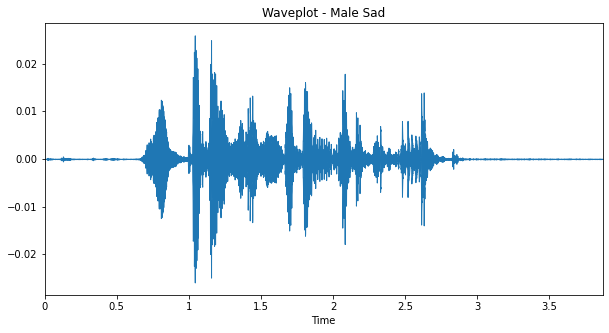

In [179]:
# MALE SAD ORIGINAL AUDIO FILE
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Sad')
plt.savefig('Waveplot_MaleSad.png')


In [180]:
# PLAY AUDIO FILE
librosa.output.write_wav('ipd.Audio Files/MaleSadOriginal.wav', x, sr)
Audio(data=x, rate=sr)

In [171]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

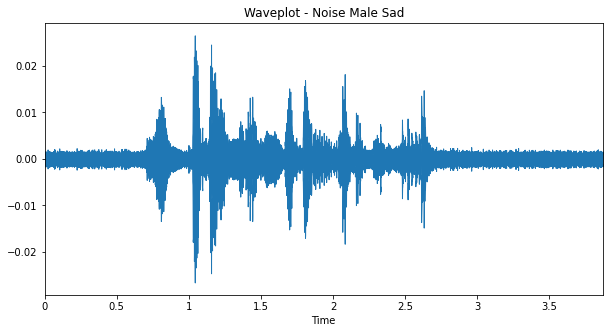

In [172]:
# ADD NOISE TO MALE SAD ORIGINAL AUDIO FILE
x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Noise Male Sad')
plt.savefig('Waveplot_MaleSadNoise.png')


In [173]:
# PLAY AUDIO FILE
librosa.output.write_wav('ipd.Audio Files/MaleSadNoise.wav', x, sr)
Audio(data=x, rate=sr)

In [176]:
# FUNCTION TO STRETCH THE TIME 
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

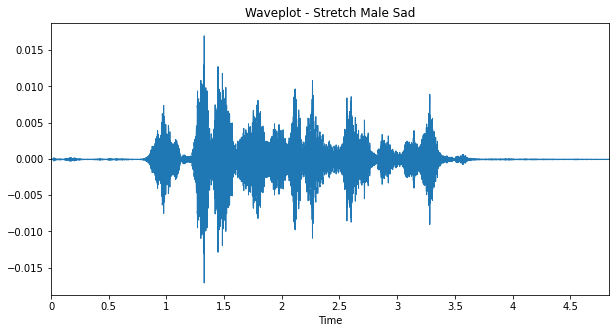

In [177]:
# ADD STRETCH TO MALE SAD ORIGINAL AUDIO FILE
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')

In [178]:
# PLAY AUDIO FILE
librosa.output.write_wav('ipd.Audio Files/MaleSadStretch.wav', x, sr)
Audio(data=x, rate=sr)

In [181]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

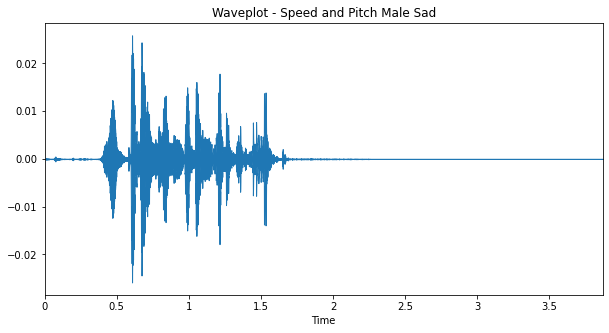

In [182]:
# ADD SPEED AND PITCH TO MALE SAD ORIGINAL AUDIO FILE
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Sad')
plt.savefig('Waveplot_MaleSadSpeedPitch.png')

In [183]:
# PLAY AUDIO FILE
librosa.output.write_wav('ipd.Audio Files/MaleSadSpeedPitch.wav', x, sr)
Audio(data=x, rate=sr)

## Apply Data Augmentation Methods to Entire Dataset

In [184]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1440


,log_spec
0,"[-71.20022, -71.20022, -71.20022, -71.20022, -..."
1,"[-70.46105, -70.46105, -70.46105, -70.46105, -..."
2,"[-64.17679, -64.39374, -64.444954, -64.26804, ..."
3,"[-73.2803, -73.2803, -73.2803, -73.2803, -73.2..."
4,"[-44.965843, -44.467876, -44.512608, -44.93480..."


In [185]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1440


,feature
0,"[-71.20022, -71.20022, -71.20022, -71.20022, -..."
1,"[-70.46105, -70.46105, -70.46105, -70.46105, -..."
2,"[-64.17679, -64.39374, -64.444954, -64.26804, ..."
3,"[-73.2803, -73.2803, -73.2803, -73.2803, -73.2..."
4,"[-44.965843, -44.467876, -44.512608, -44.93480..."


In [186]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()


1440


,feature
0,"[-70.70053, -70.70053, -70.70053, -70.70053, -..."
1,"[-72.866104, -72.866104, -72.866104, -72.86610..."
2,"[-66.413536, -66.53455, -66.388176, -66.5426, ..."
3,"[-74.76985, -74.76985, -74.76985, -74.751526, ..."
4,"[-45.93528, -45.63807, -45.699505, -45.439045,..."


In [187]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()


1440


,feature
0,"[-71.20022, -71.20022, -71.20022, -71.20022, -..."
1,"[-70.46105, -70.46105, -70.46105, -70.46105, -..."
2,"[-64.17679, -64.39374, -64.444954, -64.26804, ..."
3,"[-73.2803, -73.2803, -73.2803, -73.2803, -73.2..."
4,"[-44.965843, -44.467876, -44.512608, -44.93480..."


## Combine Tables For Modeling

In [188]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
labels = audio_df.emotion
mfcc = pd.concat([mfcc_df,labels], axis=1)
mfcc = mfcc.rename(index=str, columns={"0": "label"})

In [189]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={"0": "label"})

In [190]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={"0": "label"})

In [191]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={"0": "label"})

In [192]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,...,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,surprise
1,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,...,-70.461052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,surprise
2,-64.176788,-64.393738,-64.444954,-64.268044,-64.303825,-64.468147,-64.468147,-64.468147,-64.468147,-64.468147,...,-64.468147,-64.468147,-64.468147,-64.422607,-64.364937,-64.468147,-64.465858,-64.354759,-64.385941,angry
3,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.255249,-73.086319,-73.234695,-73.280296,-73.280296,...,-73.029083,-73.021973,-73.157417,-73.278503,-73.280296,-73.272202,-73.042091,-72.969475,-73.264915,fear
4,-44.965843,-44.467876,-44.512608,-44.934807,-44.679760,-44.350895,-45.161110,-46.124241,-45.938686,-46.116108,...,-42.546494,-43.290047,-42.981064,-43.380680,-44.499775,-44.815922,-45.377876,-45.876091,-46.404274,fear


## CNN

In [194]:
# STRATIFIED SHUFFLE SPLIT TO HANDLE CLASS IMBALANCE
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
xxx = StratifiedShuffleSplit(1, test_size=0.25, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

In [197]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


In [198]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [199]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [200]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [201]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(1440, 259, 1)

In [202]:
# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_292 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_195 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_292 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_294 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_196 (MaxPoolin (None, 2, 128)            0         
_________________________________________________________________
dropout_293 (Dropout)        (None, 2, 128)            0         
__________

In [ ]:
# FIT MODEL AND SAVE BEST MODEL BASED ON VAL_ACCURACY
checkpoint = ModelCheckpoint("best_aug_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=32, epochs=100, validation_data=(X_test, y_test),callbacks=[checkpoint])



In [66]:
# FIT MODEL AND SAVE BEST MODEL BASED ON VAL_ACCURACY
checkpoint = ModelCheckpoint("best_aug_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=32, epochs=100, validation_data=(X_test, y_test),callbacks=[checkpoint])


Train on 4320 samples, validate on 1440 samples
Epoch 1/100
4320/4320 [==============================] - 15s 3ms/step - loss: 0.9885 - acc: 0.6562 - val_loss: 1.0989 - val_acc: 0.6299
Epoch 2/100
4320/4320 [==============================] - 15s 4ms/step - loss: 0.9791 - acc: 0.6576 - val_loss: 1.0793 - val_acc: 0.6354
Epoch 3/100
4320/4320 [==============================] - 15s 3ms/step - loss: 0.9725 - acc: 0.6718 - val_loss: 1.0746 - val_acc: 0.6486
Epoch 4/100
4320/4320 [==============================] - 15s 4ms/step - loss: 0.9490 - acc: 0.6782 - val_loss: 1.0647 - val_acc: 0.6486
Epoch 5/100
4320/4320 [==============================] - 16s 4ms/step - loss: 0.9379 - acc: 0.6794 - val_loss: 1.0496 - val_acc: 0.6646
Epoch 6/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.9172 - acc: 0.6889 - val_loss: 1.0388 - val_acc: 0.6639
Epoch 7/100
4320/4320 [==============================] - 14s 3ms/step - loss: 0.9208 - acc: 0.6852 - val_loss: 1.0401 - val_acc: 0.6500


4320/4320 [==============================] - 14s 3ms/step - loss: 0.5052 - acc: 0.8475 - val_loss: 0.7523 - val_acc: 0.8007
Epoch 61/100
4320/4320 [==============================] - 15s 3ms/step - loss: 0.4977 - acc: 0.8491 - val_loss: 0.7379 - val_acc: 0.8187
Epoch 62/100
4320/4320 [==============================] - 16s 4ms/step - loss: 0.4758 - acc: 0.8558 - val_loss: 0.7272 - val_acc: 0.8097
Epoch 63/100
4320/4320 [==============================] - 16s 4ms/step - loss: 0.5019 - acc: 0.8493 - val_loss: 0.7491 - val_acc: 0.7986
Epoch 64/100
4320/4320 [==============================] - 15s 3ms/step - loss: 0.4839 - acc: 0.8539 - val_loss: 0.7375 - val_acc: 0.8069
Epoch 65/100
4320/4320 [==============================] - 15s 3ms/step - loss: 0.4876 - acc: 0.8627 - val_loss: 0.7460 - val_acc: 0.8111
Epoch 66/100
4320/4320 [==============================] - 13s 3ms/step - loss: 0.4701 - acc: 0.8565 - val_loss: 0.7534 - val_acc: 0.8021
Epoch 67/100
4320/4320 [==============================

In [67]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1440/1440 [==============================] - 2s 1ms/step
Loss of the model is -  0.6652009520265791
1440/1440 [==============================] - 1s 963us/step
Accuracy of the model is -  84.16666666666667 %


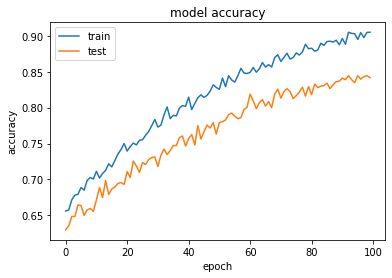

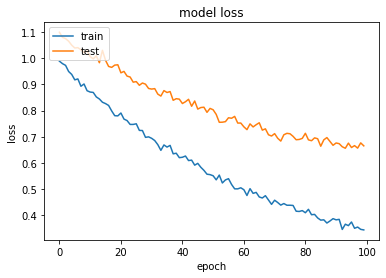

In [68]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model.png')
plt.show()

In [88]:
# OBTAIN PREDICTIONS OF TEST SET TO COMPARE TO ACTUAL VALUES
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
actual=y_test.argmax(axis=1)

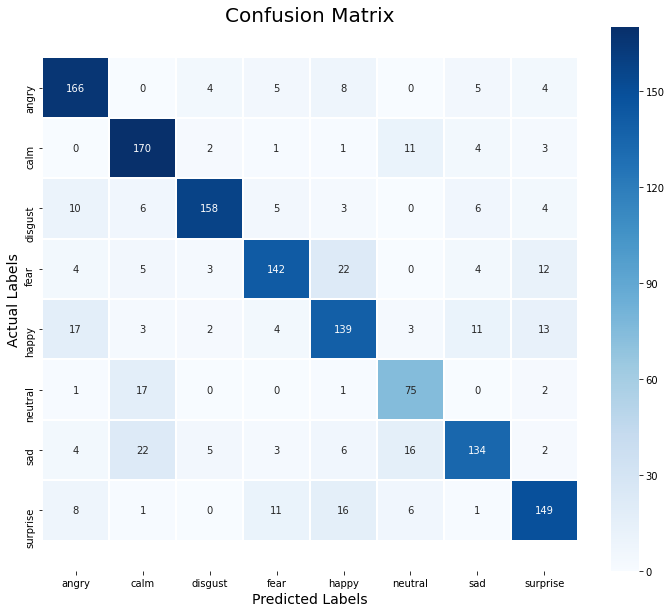

In [89]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [205]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,sad,neutral
141,calm,calm
142,fear,fear
143,disgust,disgust
144,surprise,calm
145,disgust,disgust
146,fear,angry
147,sad,disgust
148,happy,happy
149,calm,calm


In [206]:
# SAVE DATAFRAME TO HTML
finaldf[140:150].to_html('Augmented_Model_Predictions.html')

## Hyperparameter Tuning

In [113]:
# STRATIFIED SHUFFLE SPLIT
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
SSS = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in SSS.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [114]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [115]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [116]:
# RESHAPE DATA TO 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [117]:
# CREATE FUNCTION FOR KERAS CLASSIFIER
def make_classifier(optimizer='adam'):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.summary()
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [119]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
model = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [50, 75, 100],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 2, 128)            0         
__________

Epoch 1/1
3687/3687 [==============================] - 11s 3ms/step - loss: 2.0574 - acc: 0.2902
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 12s 3ms/step - loss: 2.0376 - acc: 0.2823
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 15s 4ms/step - loss: 2.0277 - acc: 0.2750
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 12s 3ms/step - loss: 2.0490 - acc: 0.2758
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_79 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 12s 3ms/step - loss: 2.0612 - acc: 0.2685
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 14s 4ms/step - loss: 2.0647 - acc: 0.2712
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_109 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_110 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_74 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 17s 5ms/step - loss: 2.0622 - acc: 0.2745
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_124 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_126 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 13s 4ms/step - loss: 2.0584 - acc: 0.2842
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_139 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_93 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_139 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_94 (MaxPooling (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 13s 4ms/step - loss: 2.0606 - acc: 0.2777
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_154 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_154 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 14s 4ms/step - loss: 2.0847 - acc: 0.2672
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_169 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_113 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_169 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 16s 4ms/step - loss: 2.0529 - acc: 0.2807
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_184 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_123 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_184 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_124 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 15s 4ms/step - loss: 2.0597 - acc: 0.2634
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_199 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_200 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_133 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_199 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 16s 4ms/step - loss: 2.0513 - acc: 0.2810
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_214 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_215 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_143 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_214 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_144 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 14s 4ms/step - loss: 2.0724 - acc: 0.2723
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_229 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_230 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_153 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_229 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_154 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 15s 4ms/step - loss: 2.0840 - acc: 0.2723
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_244 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_245 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_163 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_244 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_246 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_164 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 16s 4ms/step - loss: 2.0637 - acc: 0.2832
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_259 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_260 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_173 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_259 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 17s 5ms/step - loss: 2.0613 - acc: 0.2742
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_274 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_183 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_274 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_276 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_184 (MaxPoolin (None, 2, 128)            0         
_____________________________________________

Epoch 1/1
3687/3687 [==============================] - 19s 5ms/step - loss: 2.0769 - acc: 0.2737
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_289 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_290 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_193 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_289 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_291 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_194 (MaxPoolin (None, 2, 128)            0         
_____________________________________________